# Keras various tests


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
import numpy as np

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Predictions from zero input or random predictions

Let's consider simple classification problem : $ y = round(x_1 + x_2)$

Then we setup training data to a zero vector and see predictions and model evaluation

In [109]:
nb_samples = 1000
nb_features = 2
nb_classes = 10

while True:
    x = nb_classes*0.5*np.random.random((nb_samples, nb_features))
    y = np.round(np.sum(x, axis=1)) % nb_classes
    if len(np.unique(y)) == nb_classes:
        break

x_train_nonzero, x_val, y_train, y_val = train_test_split(x,y, train_size=0.75)

x_train_zero = np.zeros_like(x_train_nonzero)

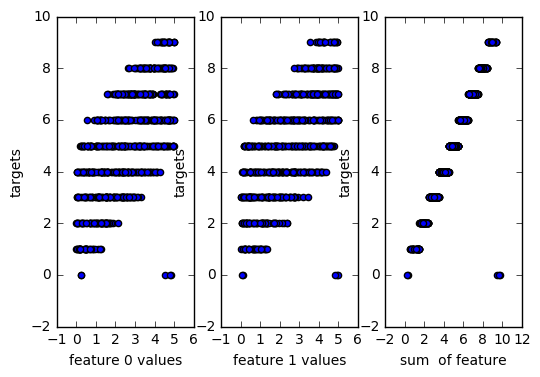

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot(131)
plt.scatter(x_train_nonzero[:, 0], y_train)
plt.xlabel('feature 0 values')
plt.ylabel('targets')
plt.subplot(132)
plt.scatter(x_train_nonzero[:, 1], y_train)
plt.xlabel('feature 1 values')
plt.ylabel('targets')
plt.subplot(133)
plt.scatter(np.sum(x_train_nonzero, axis=1), y_train)
plt.xlabel('sum  of feature')
plt.ylabel('targets')

In [111]:
def create_model():
    model = Sequential()
    model.add(Dense(15, init='uniform', input_shape=(nb_features,), activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

for x_train in [x_train_nonzero, x_train_zero]:

    model = create_model()
    model.summary()

    y_train_ = np_utils.to_categorical(y_train)
    y_val_ = np_utils.to_categorical(y_val)
    
    model.fit(x_train, y_train_, nb_epoch=1000, batch_size=100, verbose=0)
    scores = model.evaluate(x_val, y_val_, verbose=0)
    print "Model Accuracy : %.2f%%" % (scores[1]*100)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_134 (Dense)                (None, 15)            45          dense_input_65[0][0]             
____________________________________________________________________________________________________
dense_135 (Dense)                (None, 10)            160         dense_134[0][0]                  
Total params: 205
____________________________________________________________________________________________________
Model Accuracy : 95.60%
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_136 (Dense)                (None, 15)            45          dense_input_66[0][0]             
_________________________________________________

Run Cross-Validation with on zero train vector

In [101]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [115]:
estimator = KerasClassifier(build_fn=create_model, nb_epoch=1000, batch_size=100, verbose=0)
dummy_y = np_utils.to_categorical(y)

In [116]:
results = cross_val_score(estimator, x, dummy_y, cv=5)
print("CV on normal data: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

CV on normal data: 96.50% (1.18%)


In [117]:
results = cross_val_score(estimator, np.zeros_like(x), dummy_y, cv=5)
print("CV on zero data: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

CV on zero data: 16.00% (2.10%)


### Compare with random predictions

In [120]:
y_train_ = np_utils.to_categorical(y_train)
estimator.fit(x_train_zero, y_train_)

In [122]:
from sklearn.metrics import accuracy_score

In [183]:
max_random_accuracy = 0.0
for i in range(10000):
    y_random_pred = np.random.randint(10, size=(y_val.shape))
    acc = accuracy_score(y_val, y_random_pred)
    if max_random_accuracy < acc:
        max_random_accuracy = acc

y_pred = estimator.predict(x_val)

print max_random_accuracy, accuracy_score(y_val, y_pred)

0.184 0.192
